In [ ]:
!git clone https://github.com/SrinidhiBharadwaj/Scratch.git

Cloning into 'Scratch'...
remote: Enumerating objects: 4810, done.
remote: Counting objects: 100% (1182/1182), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 4810 (delta 994), reused 1182 (delta 994), pack-reused 3628
Receiving objects: 100% (4810/4810), 130.85 MiB | 29.71 MiB/s, done.
Resolving deltas: 100% (2628/2628), done.


In [ ]:
from unetModel import simple_unet_model 
import keras
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import glob

In [ ]:
image_directory = '/content/Scratch/FinalDataset/images/'
mask_directory = '/content/Scratch/FinalDataset/masks/'

In [ ]:
SIZE = 128
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.
#Load the images from the dataset and save as numpy arrays
images = os.listdir(image_directory)
count=0
#Load the images from the dataset and save as numpy arrays
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_name)
        image = cv2.imread(image_directory+image_name, 0)
        mask = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE, SIZE))
        mask_dataset.append(np.array(mask))

In [ ]:
#Normalize images and rescale masks between 0 and 1
import tensorflow as tf
image_dataset = np.expand_dims(tf.keras.utils.normalize(np.array(image_dataset), axis=1),3)
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.
image_dataset.shape

(768, 128, 128, 1)

In [ ]:
#Split the dataset into training and testing to avoid over fitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

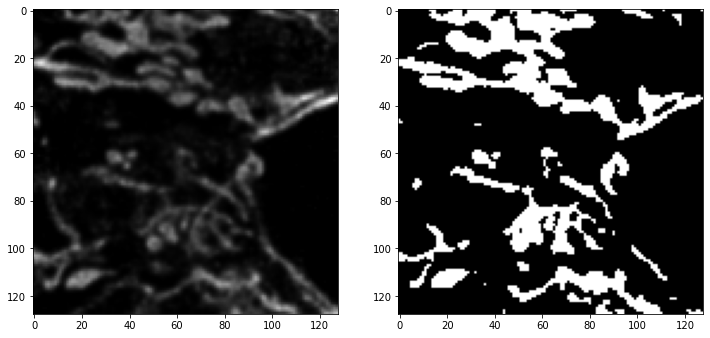

In [ ]:
#Sanity check

import random
import numpy as np
image_number = random.randint(0, 767)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128,128)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128,128)), cmap='gray')
plt.show()

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/50
44/44 [==============================] - 51s 91ms/step - loss: 0.4816 - accuracy: 0.9107 - val_loss: 0.0749 - val_accuracy: 0.9721
Epoch 2/50
44/44 [==============================] - 2s 38ms/step - loss: 0.0648 - accuracy: 0.9773 - val_loss: 0.0531 - val_accuracy: 0.9793
Epoch 3/50
44/44 [==============================] - 2s 39ms/step - loss: 0.0421 - accuracy: 0.9823 - val_loss: 0.0457 - val_accuracy: 0.9804
Epoch 4/50
44/44 [==============================] - 2s 39ms/step - loss: 0.0340 - accuracy: 0.9845 - val_loss: 0.0407 - val_accuracy: 0.9830
Epoch 5/50
44/44 [==============================] - 2s 39ms/step - loss: 0.0302 - accuracy: 0.9863 - val_loss: 0.0434 - val_accuracy: 0.9819
Epoch 6/50
44/44 [==============================] - 2s 39ms/step - loss: 0.0270 - accuracy: 0.9884 - val_loss: 0.0337 - val_accuracy: 0.9864
Epoch 7/50
44/44 [==============================] - 2s 39ms/step - loss: 0.0263 - accuracy: 0.9888 - val_loss: 0.0361 - val_accuracy: 0.9845
Epoch 8/50
4

In [ ]:
model.save('ModelBuiltOnCuratedData.hdf5')

In [ ]:
model = get_model()
model.load_weights('/content/ModelBuiltOnCuratedData.hdf5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

In [ ]:
	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

KeyboardInterrupt: ignored

In [ ]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.7489000965768859


In [ ]:
!pip install patchify

In [60]:
import tifffile as tiff
from tifffile import imread, imwrite
from patchify import patchify, unpatchify
from skimage.transform import resize
segmentedImages = []

data = imread('/content/JohTestImage.tif')
resized_data = resize(data, (57, 512, 512))
imwrite('/content/JohTestImageResized.tif', resized_data, planarconfig='CONTIG')

large_image_stack = tiff.imread('/content/JohTestImageResized.tif')

print(large_image_stack.shape)
count = 0
for img in range(large_image_stack.shape[0]):
    predicted_patches = []
    large_image = large_image_stack[img]
    patches_img = patchify(large_image, (128, 128), step=128)  #Step=256 for 256 patches means no overlap 
 
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]): 
            single_patch = patches_img[i,j,:,:]
            single_patch_norm = np.expand_dims(tf.keras.utils.normalize(np.array(single_patch), axis=1),2)
            single_patch_input=np.expand_dims(single_patch_norm, 0)
            single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.1).astype(np.uint8)
           # single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]
            predicted_patches.append(single_patch_prediction)

    predicted_patches = np.array(predicted_patches)
    predicted_patches_reshaped = np.reshape(predicted_patches, (patches_img.shape[0], patches_img.shape[1], 128,128) )
    reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
    segmentedImages.append(reconstructed_image)
    # im = Image.fromarray(reconstructed_image)
    # im.save('finalSegmentedImage'+str(count)+'.tif')
    #imsave('finalSegmentedImage'+str(count)+'.tif', reconstructed_image)
    # count+=1
    # plt.imshow(reconstructed_image, cmap='gray')
    # plt.savefig('/content/OutputMasks/finalSegmentedImage'+str(count)+'.tif')
    
    # plt.show()

hopefullyTheFinalImage = np.array(segmentedImages)
# plt.figure(figsize=(16, 8))
# plt.imshow(hopefullyTheFinalImage, cmap='gray')
 

(57, 512, 512)


In [61]:
hopefullyTheFinalImage.shape

(57, 512, 512)

In [62]:
from tifffile import imsave
imsave('finalSegmentedImage.tif', hopefullyTheFinalImage)


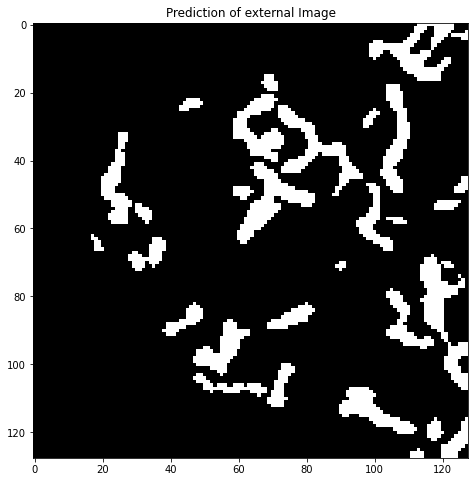

In [ ]:
test_img_other = cv2.imread('/content/testImage0_image_0_21.tif', 0)
test_img_other = cv2.resize(test_img_other, (SIZE, SIZE))
test_img_other_norm = np.expand_dims(tf.keras.utils.normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.1).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

In [58]:
!zip -r /content/IndividualMasks.zip /content/OutputMasks

  adding: content/OutputMasks/ (stored 0%)
  adding: content/OutputMasks/finalSegmentedImage19.tif (deflated 96%)
  adding: content/OutputMasks/finalSegmentedImage10.tif (deflated 97%)
  adding: content/OutputMasks/finalSegmentedImage54.tif (deflated 98%)
  adding: content/OutputMasks/finalSegmentedImage52.tif (deflated 98%)
  adding: content/OutputMasks/finalSegmentedImage56.tif (deflated 99%)
  adding: content/OutputMasks/finalSegmentedImage25.tif (deflated 96%)
  adding: content/OutputMasks/finalSegmentedImage17.tif (deflated 96%)
  adding: content/OutputMasks/finalSegmentedImage50.tif (deflated 97%)
  adding: content/OutputMasks/finalSegmentedImage26.tif (deflated 96%)
  adding: content/OutputMasks/finalSegmentedImage20.tif (deflated 96%)
  adding: content/OutputMasks/finalSegmentedImage1.tif (deflated 99%)
  adding: content/OutputMasks/finalSegmentedImage45.tif (deflated 96%)
  adding: content/OutputMasks/finalSegmentedImage49.tif (deflated 97%)
  adding: content/OutputMasks/.ipyn